In [1]:
# from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
# (model.wv['don\'t'])

In [13]:
lyrics = 'We don\'t need no education us'
words = lyrics.split(' ')
pca = PCA(n_components=2)
# vectors = []

X = model[words]
print(X.shape)
results = pca.fit_transform(model[words])

print(results)

r1 = results[0]
r2 = results[1]

lin = np.linspace(r1, r2, 100)

print(lin)
# for word in words:
#     print(word)
#     print(model[word].shape)
#     pca.fit_transform(model[word])

(6, 300)
[[-1.0482829  -1.6985768 ]
 [ 2.2712178  -0.07831976]
 [-0.1260357   0.19059786]
 [ 0.31040227  0.55622715]
 [-1.1099584   1.7782776 ]
 [-0.2973432  -0.7482061 ]]
[[-1.0482829  -1.6985768 ]
 [-1.0147525  -1.6822106 ]
 [-0.9812223  -1.6658443 ]
 [-0.9476919  -1.6494781 ]
 [-0.9141616  -1.6331118 ]
 [-0.8806313  -1.6167457 ]
 [-0.847101   -1.6003795 ]
 [-0.8135707  -1.5840132 ]
 [-0.7800404  -1.567647  ]
 [-0.7465101  -1.5512807 ]
 [-0.7129798  -1.5349145 ]
 [-0.67944944 -1.5185483 ]
 [-0.64591914 -1.502182  ]
 [-0.61238885 -1.4858158 ]
 [-0.5788585  -1.4694495 ]
 [-0.5453282  -1.4530833 ]
 [-0.5117979  -1.436717  ]
 [-0.4782676  -1.4203508 ]
 [-0.44473732 -1.4039847 ]
 [-0.41120696 -1.3876184 ]
 [-0.37767667 -1.3712522 ]
 [-0.34414637 -1.3548859 ]
 [-0.31061602 -1.3385197 ]
 [-0.27708572 -1.3221534 ]
 [-0.24355543 -1.3057872 ]
 [-0.21002513 -1.289421  ]
 [-0.17649484 -1.2730548 ]
 [-0.14296448 -1.2566886 ]
 [-0.10943419 -1.2403224 ]
 [-0.07590389 -1.2239561 ]
 [-0.04237354 -1.2

In [4]:
import numpy as np
def f(a, b):
    def eq(theta, phi):
        return np.sin(a * theta) + np.cos(b * phi)
    return eq

# f(3, 4)(0.3, 0.5)

# eq = f(result[0][0], result[0][1])
# x = np.linspace(-6, 6, 30)
# y = np.linspace(-6, 6, 30)

# X, Y = np.meshgrid(x, y)
# Z = eq(X, Y)


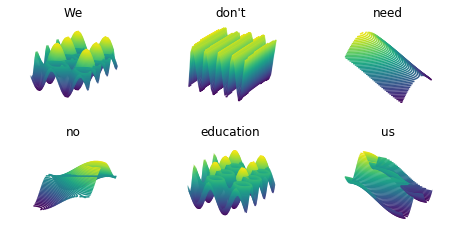

In [5]:
# fig = plt.figure()
fig = plt.figure(figsize=plt.figaspect(0.5))
# fig, axs = plt.subplots(nrows=3, ncols=6)

for i in range(results.shape[0]):
    result = results[i]
    eq = f(result[0], result[1])
    x = np.linspace(-6, 6, 30)
    y = np.linspace(-6, 6, 30)
    
    X, Y = np.meshgrid(x, y)
    Z = eq(X, Y)

    # for ax in axs.flat:
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.contour3D(X, Y, Z, 50, cmap='viridis')
    ax.set_title(words[i])
    ax.axis('off')

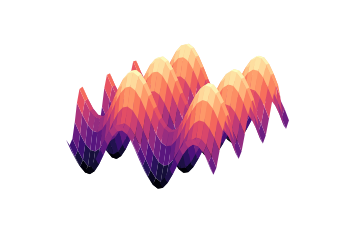

In [32]:
n_frames = lin.shape[0]
fps = 250

Zs = np.zeros((30, 30, n_frames))
x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(x, y)

for i in range(lin.shape[0]):
    result = lin[i]
    eq = f(result[0], result[1])
    Zs[:, :, i] = eq(X, Y)
    

def update_plot(i, Z, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zs[:,:,i], cmap="magma")
    ax.axis('off')
    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Y, Zs[:,:,0], color='0.75', rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, n_frames, fargs=(Zs, plot), interval=1000/fps)
# fig = plt.figure(figsize=plt.figaspect(0.1))
# for i in range(lin.shape[0]):
#     result = lin[i]
#     eq = f(result[0], result[1])
#     x = np.linspace(-6, 6, 30)
#     y = np.linspace(-6, 6, 30)
    
#     X, Y = np.meshgrid(x, y)
#     Z = eq(X, Y)
#     print(Z.shape)
#     break

#     # for ax in axs.flat:
#     ax = fig.add_subplot(1, 10, i + 1, projection='3d')
#     ax.contour3D(X, Y, Z, 50, cmap='magma')
# #     ax.set_title(words[0])
#     ax.axis('off')

In [33]:
ani.save('we-dont-250.gif',writer='imagemagick',fps=fps)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


In [29]:
plt.rcParams['animation.html'] = 'html5'
ani